<a href="https://colab.research.google.com/github/Murcha1990/Raiff_PracticalML_May2023/blob/main/Lecture_4_PracticeEDA/Raiff_EDA_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Решение задачи прогноза дохода

* Загрузка данных и их анализ
* Обучение и оценка качества модели
  + обучение модели
  + оценка качества модели
* Интерпретация результатов модели
* Сохранение результатов

Будем решать задачу прогноза дохода, а именно, *по соц-дем характеристикам людей, будет их доход выше или ниже 50к*.

## <font color='green'>1. Загрузка данных и их первичный анализ</font>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid") 

Подключаемся к БД и загружаем данные

*// импорт сертификата одноразовый, он нам каждый раз не нужен - выключим пока*

*// ставить pip и psycopg2 тоже каждый раз не будем*

In [2]:
# !mkdir -p ~/.postgresql && \
# wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
#     --output-document ~/.postgresql/root.crt && \
# chmod 0600 ~/.postgresql/root.crt

In [3]:
# !sudo apt update && sudo apt install --yes python3 python3-pip && \
# !pip3 install psycopg2-binary

In [4]:
import psycopg2
conn = psycopg2.connect("""
    host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
    port=6432
    sslmode=verify-full
    dbname=db_clients
    user=mlhs_student
    password=mlhs_student
    target_session_attrs=read-write
""")

In [5]:
query = "SELECT * from public.adult_income"
data = pd.read_sql_query(query, conn)
conn.close()

Посмотрим на данные.

*Описание аттрибутов таблицы / признаков подопытного населения*:

- **age**: количество полных лет. 
- **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
- **fnlwgt**: continuous. 
- **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
- **education-num**: continuous. 
- **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
- **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
- **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
- **race**: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black. 
- **gender**: Female, Male. 
- **capital-gain**: continuous. 
- **capital-loss**: continuous. 
- **hours-per-week**: continuous. 
- **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands. 




In [6]:
data

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25.0,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
1,38.0,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
2,28.0,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
3,44.0,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K
4,18.0,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9610,NaN,Private,200939,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,NaN,United-States,>50K
9611,NaN,Private,110592,12th,8,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,NaN,United-States,<=50K
9612,NaN,Private,167840,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0.0,2002.0,NaN,United-States,<=50K
9613,NaN,Private,274883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0.0,0.0,NaN,United-States,>50K


In [7]:
data.shape

(9615, 15)

In [8]:
data.dtypes

age                float64
workclass           object
fnlwgt               int64
education           object
educational-num      int64
marital-status      object
occupation          object
relationship        object
race                object
gender              object
capital-gain       float64
capital-loss       float64
hours-per-week     float64
native-country      object
income              object
dtype: object

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9615 entries, 0 to 9614
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              8961 non-null   float64
 1   workclass        9615 non-null   object 
 2   fnlwgt           9615 non-null   int64  
 3   education        9615 non-null   object 
 4   educational-num  9615 non-null   int64  
 5   marital-status   9615 non-null   object 
 6   occupation       9615 non-null   object 
 7   relationship     9615 non-null   object 
 8   race             9614 non-null   object 
 9   gender           9614 non-null   object 
 10  capital-gain     9614 non-null   float64
 11  capital-loss     9614 non-null   float64
 12  hours-per-week   8543 non-null   float64
 13  native-country   9614 non-null   object 
 14  income           9614 non-null   object 
dtypes: float64(4), int64(2), object(9)
memory usage: 1.1+ MB


## Сохранение данных

In [10]:
data.to_csv("adult_income.csv", index=False)

In [11]:
# data = pd.read_csv("adult_income.csv")

# Разведочный анализ данных

## 1. Оценка качества данных
* пропущенные значения
* ошибочные значения

In [12]:
len(data)

9615

Посмотрим, есть ли в данных пропущенные значения.

In [13]:
data.isna().sum()

age                 654
workclass             0
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation            0
relationship          0
race                  1
gender                1
capital-gain          1
capital-loss          1
hours-per-week     1072
native-country        1
income                1
dtype: int64

Что за единички?

In [14]:
data[data["race"].isna()]

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
8612,49.0,Private,123681,Assoc-acdm,12,Separated,Sales,Unmarried,None,None,NaN,NaN,NaN,None,None


* пропусков меньше 1% - можно выкинуть строки с пропусками

У нас куча пропусков в одной и той же строке - одна строка нам погоды не делает, следовательно выкидываем эту строку

In [15]:
data = data.drop([data.index[8612]])

In [16]:
data.isna().sum()

age                 654
workclass             0
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation            0
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week     1071
native-country        0
income                0
dtype: int64

* пропусков меньше 10% - заполняем пропуск каким-то значением
Пропуски в числовых признаках обычно заполняют средним значением или медианой.

In [17]:
len(data[data["age"].isna()]) / len(data)

0.0680257957145829

С полем age всё так и есть, значит заполняем, к примеру, средним 

На всякий случай проверим, насколько у нас близки среднее и медиана

(вряд ли возраст у нас улетит в космос, поэтому медиана тут не особо имеет математический смысл)

In [18]:
median = data['age'].median()
mean = data['age'].mean()
print(median, mean)

data['age'].fillna(mean, inplace=True)

37.0 38.72142857142857


In [19]:
data.isna().sum()

age                   0
workclass             0
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation            0
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week     1071
native-country        0
income                0
dtype: int64

А если пропусков больше 10%?

Нам не сказали, что делать в этом случае... если просто в лоб заполним медианой, то можем всё испортить

In [20]:
len(data[data["hours-per-week"].isna()]) / len(data)

0.11140004160599126

Посмотрим на эти данные

In [21]:
data[data["hours-per-week"].isna()]

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
16,45.000000,Self-emp-not-inc,432824,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,7298.0,0.0,NaN,United-States,>50K
20,44.000000,Private,26669,Assoc-voc,11,Widowed,Exec-managerial,Unmarried,White,Female,0.0,0.0,NaN,United-States,<=50K
35,32.000000,Private,136921,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0.0,0.0,NaN,United-States,<=50K
55,54.000000,Private,186272,Some-college,10,Married-civ-spouse,Transport-moving,Husband,White,Male,3908.0,0.0,NaN,United-States,<=50K
77,39.000000,Private,118429,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0.0,0.0,NaN,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9610,38.721429,Private,200939,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,NaN,United-States,>50K
9611,38.721429,Private,110592,12th,8,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,NaN,United-States,<=50K
9612,38.721429,Private,167840,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0.0,2002.0,NaN,United-States,<=50K
9613,38.721429,Private,274883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0.0,0.0,NaN,United-States,>50K


Посмотрим, чем заполнены эти данные в случаях, когда они заполнены

In [22]:
median = data['hours-per-week'].median()
mean = data['hours-per-week'].mean()
print(median, mean)

40.0 40.475125834016154


В среднем работают по 40 часов в неделю, что логично

У каких работничков отсутствуют данные о часах в неделю:

In [23]:
data[data["hours-per-week"].isna()].groupby("workclass")["age"].count()

workclass
?                    59
Federal-gov          23
Local-gov            64
Private             757
Self-emp-inc         29
Self-emp-not-inc     92
State-gov            47
Name: age, dtype: int64

Больше всего тут непонятных приватных (это кто вообще?)

Посмотрим на них:

In [24]:
data[data["workclass"] == "Private"]

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25.000000,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
1,38.000000,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
3,44.000000,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K
5,34.000000,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0.0,0.0,30.0,United-States,<=50K
8,24.000000,Private,369667,Some-college,10,Never-married,Other-service,Unmarried,White,Female,0.0,0.0,40.0,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9610,38.721429,Private,200939,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,NaN,United-States,>50K
9611,38.721429,Private,110592,12th,8,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,NaN,United-States,<=50K
9612,38.721429,Private,167840,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0.0,2002.0,NaN,United-States,<=50K
9613,38.721429,Private,274883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0.0,0.0,NaN,United-States,>50K


Посмотрим долю незаполненных данных по типам работы:

In [25]:
data[data["hours-per-week"].isna()].groupby("workclass")["age"].count() / data.groupby("workclass")["age"].count()

workclass
?                   0.101027
Federal-gov         0.082437
Local-gov           0.105090
Never-worked             NaN
Private             0.115168
Self-emp-inc        0.082153
Self-emp-not-inc    0.117647
State-gov           0.109557
Without-pay              NaN
Name: age, dtype: float64

А что у нас с бездельниками и волонтерами?

In [26]:
data[(data["workclass"] == "Never-worked") | (data["workclass"] == "Without-pay")]

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
2647,19.0,Without-pay,43627,HS-grad,9,Never-married,Other-service,Own-child,White,Male,0.0,0.0,10.0,United-States,<=50K
2836,74.0,Without-pay,216001,7th-8th,4,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,20.0,United-States,<=50K
5798,51.0,Without-pay,124963,Assoc-acdm,12,Married-civ-spouse,Sales,Husband,White,Male,0.0,0.0,45.0,United-States,<=50K
7870,17.0,Never-worked,131593,11th,7,Never-married,?,Own-child,Black,Female,0.0,0.0,20.0,United-States,<=50K
7976,64.0,Without-pay,209291,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0.0,0.0,60.0,United-States,>50K


А что за люди-вопросики?

In [27]:
data[data["workclass"] == "?"]

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
4,18.000000,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K
6,29.000000,?,227026,HS-grad,9,Never-married,?,Unmarried,Black,Male,0.0,0.0,40.0,United-States,<=50K
13,58.000000,?,299831,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,0.0,0.0,35.0,United-States,<=50K
22,72.000000,?,132015,7th-8th,4,Divorced,?,Not-in-family,White,Female,0.0,0.0,6.0,United-States,<=50K
34,65.000000,?,191846,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9541,18.000000,?,30246,11th,7,Never-married,?,Own-child,White,Female,0.0,0.0,NaN,United-States,<=50K
9543,20.000000,?,49819,Some-college,10,Never-married,?,Own-child,White,Female,0.0,0.0,NaN,United-States,<=50K
9568,38.721429,?,150250,Masters,14,Married-civ-spouse,?,Husband,White,Male,0.0,1510.0,NaN,United-States,<=50K
9573,38.721429,?,305145,Bachelors,13,Widowed,?,Not-in-family,White,Male,0.0,0.0,NaN,United-States,<=50K


Посмотрим еще медианы и средние значения, характерные для каждого типа работы:

In [28]:
for key in data["workclass"].unique():
    median = data[data["workclass"] == key]['hours-per-week'].median()
    mean = data[data["workclass"] == key]['hours-per-week'].mean()
    print(key, median, mean)

Private 40.0 40.351444291609354
Local-gov 40.0 40.90091743119266
? 40.0 31.756190476190476
Self-emp-not-inc 40.0 44.88985507246377
Federal-gov 40.0 42.15625
State-gov 40.0 38.175392670157066
Self-emp-inc 48.0 48.23456790123457
Without-pay 32.5 33.75
Never-worked 20.0 20.0


Итого, по сильно выбивающимся из средних показателей безработным и волонтерам у нас пропусков нет

По людям-вопросикам вообще непонятно, что делать - по ним еще и профессия не ясна... м.б. дропнуть всех NaN-ов из этой категории?

В общем, пока не заморачиваемся, а просто заполним пропуски в столбце hours-per-week медианным значением по всей табличке

In [29]:
median = data['hours-per-week'].median()
data['hours-per-week'].fillna(median, inplace=True)

In [30]:
data.isna().sum()

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

## Ошибочные значения

Смотрим число различных значений в нечисловых столбцах

In [31]:
for i, column in enumerate(data.columns):
    if column not in data.describe().columns:
        print(column)
        print(data[column].value_counts())

workclass
Private             6573
Self-emp-not-inc     782
Local-gov            609
?                    584
State-gov            429
Self-emp-inc         353
Federal-gov          279
Without-pay            4
Never-worked           1
Name: workclass, dtype: int64
education
HS-grad         3121
Some-college    2125
Bachelors       1598
Masters          545
Assoc-voc        412
11th             358
Assoc-acdm       314
10th             273
7th-8th          186
Prof-school      146
9th              143
12th             121
Doctorate        106
5th-6th           98
1st-4th           48
Preschool         20
Name: education, dtype: int64
marital-status
Married-civ-spouse       4307
Never-married            3238
Divorced                 1303
Widowed                   330
Separated                 297
Married-spouse-absent     130
Married-AF-spouse           9
Name: marital-status, dtype: int64
occupation
Prof-specialty       1222
Exec-managerial      1213
Craft-repair         1183
Adm-cleric

Как-то подозрительно всё-таки вглядят вопросики в столбцах workclass, occupation и native-country

Ну, допустим native-country мы можем заполнить страной по-умолчанию, т.е. сильно преобладающей в выборке

In [32]:
data['native-country'] = data['native-country'].replace('?', 'United-States')

In [33]:
data['native-country'].value_counts()

United-States                 8845
Mexico                         186
Philippines                     51
Germany                         41
Puerto-Rico                     41
Canada                          34
India                           34
El-Salvador                     30
Cuba                            28
England                         21
Haiti                           20
South                           20
Poland                          20
China                           19
Dominican-Republic              18
Portugal                        18
Guatemala                       17
Jamaica                         15
Italy                           15
Columbia                        13
Ecuador                         13
Japan                           12
Peru                            11
Thailand                        10
Nicaragua                        9
Vietnam                          7
Taiwan                           7
Greece                           7
France              

С полем workclass, пожалуй, поступим так же:

In [34]:
data['workclass'] = data['workclass'].replace('?', 'Private')

In [35]:
data['workclass'].value_counts()

Private             7157
Self-emp-not-inc     782
Local-gov            609
State-gov            429
Self-emp-inc         353
Federal-gov          279
Without-pay            4
Never-worked           1
Name: workclass, dtype: int64

А вот с профессией так не получится, там нет преобладающего значения

In [36]:
# data['is_date'] = data['date'].apply(lambda x: 1 if x.isna() else 0)

## Основные числовые характеристики

Распределение целевой переменой

In [37]:
data['income'].value_counts(normalize=True)

<=50K    0.765134
>50K     0.234866
Name: income, dtype: float64

In [38]:
data.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,9614.000000,9.614000e+03,9614.000000,9614.000000,9614.000000,9614.000000
mean,38.721429,1.882948e+05,10.080092,1121.998232,87.926669,40.422197
std,13.355951,1.051352e+05,2.562733,7890.578253,404.085647,11.633285
min,17.000000,1.376900e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.154652e+05,9.000000,0.000000,0.000000,40.000000
50%,38.000000,1.778450e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.374175e+05,12.000000,0.000000,0.000000,43.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,3770.000000,99.000000


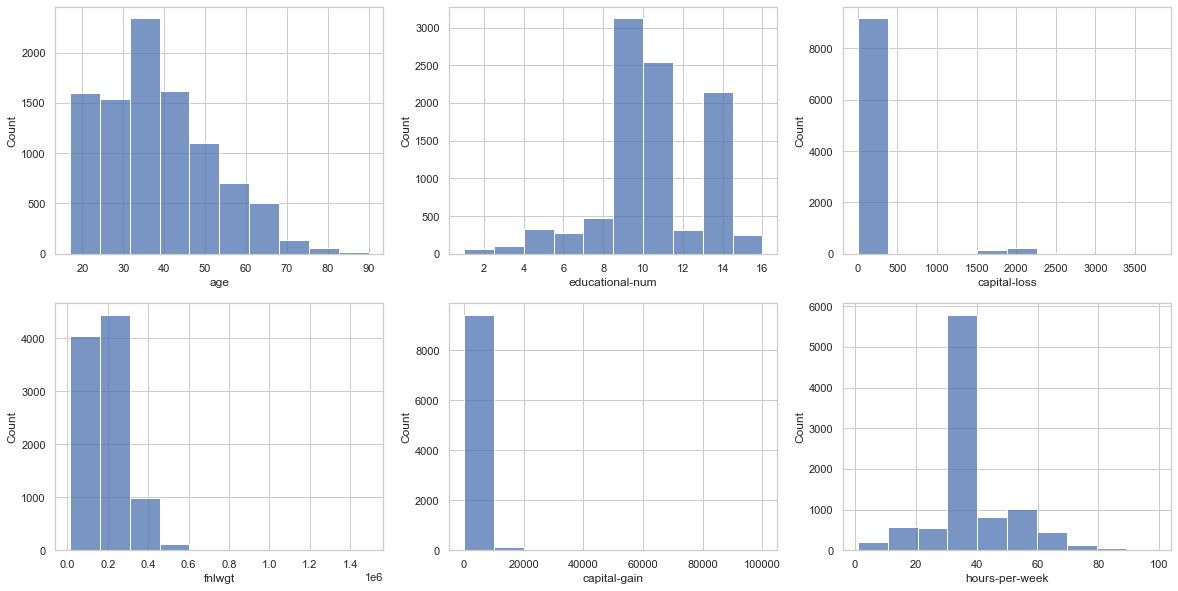

In [39]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, column in enumerate(data.describe().columns):
    sns.histplot(data[column], ax=axes[i % 2, i // 2], bins=10)
plt.show()

In [40]:
data.describe(include='object') # категориальные колонки

,workclass,education,marital-status,occupation,relationship,race,gender,native-country,income
count,9614,9614,9614,9614,9614,9614,9614,9614,9614
unique,8,16,7,15,6,5,2,40,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,7157,3121,4307,1222,3800,8255,6409,8845,7356


У нас целевая колонка текстовая

Добавим пока такую же, но бинарную, чтобы посмотреть корреляцию

In [41]:
data["income_bool"] = data["income"] == ">50K"
data['income_bool'].value_counts(normalize=True)

False    0.765134
True     0.234866
Name: income_bool, dtype: float64

In [42]:
corr = data.corr() # строим матрицу корреляций

corr.style.background_gradient(cmap='coolwarm')

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,income_bool
age,1.000000,-0.079770,0.002383,0.073273,0.048926,0.081907,0.214954
fnlwgt,-0.079770,1.000000,-0.024398,-0.005989,-0.000409,-0.002930,-0.003089
educational-num,0.002383,-0.024398,1.000000,0.132639,0.083546,0.130397,0.320775
capital-gain,0.073273,-0.005989,0.132639,1.000000,-0.030944,0.094505,0.221998
capital-loss,0.048926,-0.000409,0.083546,-0.030944,1.000000,0.050089,0.139776
hours-per-week,0.081907,-0.002930,0.130397,0.094505,0.050089,1.000000,0.217293
income_bool,0.214954,-0.003089,0.320775,0.221998,0.139776,0.217293,1.000000


Вопрос века: нужно ли нам какие-то данные удалить?

Еще один вопрос века: что значит отрицаельная корреляция поля fnlwgt со всеми подряд другими полями? Что это за поле вообще?

In [43]:
corrcoef_dct = {}
for col in data.columns:
    try:
#         print(col, np.corrcoef(data[col], data['income_bool'])[0][1])
#         corrcoef_arr.append(np.corrcoef(data[col], data['income_bool'])[0][1])
        corrcoef_dct[col] = np.corrcoef(data[col], data['income_bool'])[0][1]
    except:
        pass
sorted_corrcoef_dct = sorted(corrcoef_dct.items(), key=lambda x:x[1], reverse=True)
sorted_corrcoef_dct

[('income_bool', 0.9999999999999999),
 ('educational-num', 0.3207754524730229),
 ('capital-gain', 0.2219983539033911),
 ('hours-per-week', 0.2172928389926224),
 ('age', 0.2149535894898411),
 ('capital-loss', 0.13977556008529074),
 ('fnlwgt', -0.0030885468367829474)]

## Визуализация данных

Посмотрим диаграммы для признаков, имеющих наибольшую корреляцию с целевой переменной

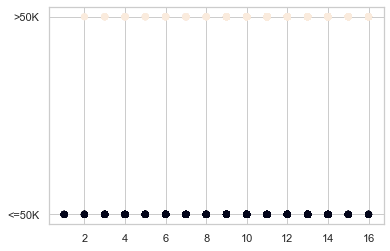

In [44]:
plt.scatter(data['educational-num'], data['income'], c=data['income_bool'])

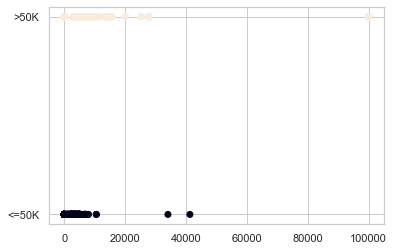

In [45]:
plt.scatter(data['capital-gain'], data['income'], c=data['income_bool'])

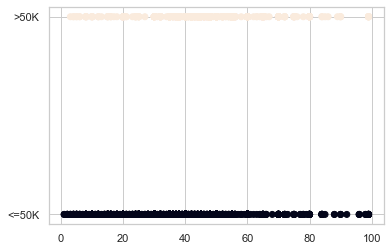

In [46]:
plt.scatter(data['hours-per-week'], data['income'], c=data['income_bool'])

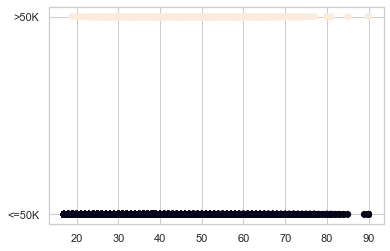

In [47]:
plt.scatter(data['age'], data['income'], c=data['income_bool'])

<AxesSubplot:>

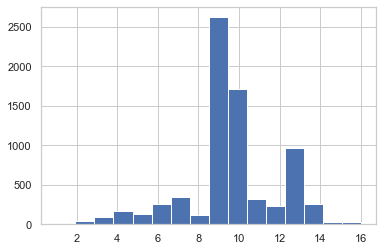

In [48]:
data[data.income_bool == 0]['educational-num'].hist(bins=16)

<AxesSubplot:>

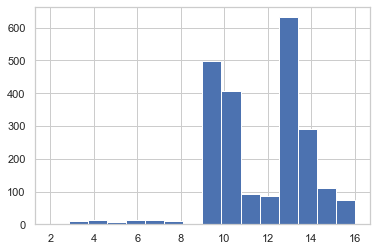

In [49]:
data[data.income_bool == 1]['educational-num'].hist(bins=16)

Посчитаем среднее значение признака с наибольшей корреляцию для клиентов с высоким и с низким доходом, используйте groupby.

In [50]:
data.groupby('income')['educational-num'].mean()

income
<=50K     9.624660
>50K     11.563773
Name: educational-num, dtype: float64

## <font color='green'>2.1. Обучение модели</font>



Сформируем матрицу X объект-признак и вектор y целевой переменной.

In [ ]:
X = data.drop('churn', axis=1) # матрица объект-признак
y = data['churn'] # целевая переменная

Когда мы решаем задачу классификации, мы можем захотеть предсказывать не только классы, но и их вероятности. Для целей бизнеса, например, полезно знать, с какой вероятностью клиент вернет кредит (а не просто - вернет кредит или не вернет). Например, если клиент уйдет из банка с вероятностью 0.95, то это очень ненадежный клиент. А если с вероятностью 0.52  - этот клиент под вопросом. Но с точки зрения бинарной классификации для обоих клиентов модель предскажет, что они уйдут, так как стандартный порог перевода вероятности в классы - 0.5. 

* задача классификации, в которой модель предсказывает только классы - это **жесткая классификация**
* если же классификатор предсказывает вероятности классов - это **мягкая классификация**

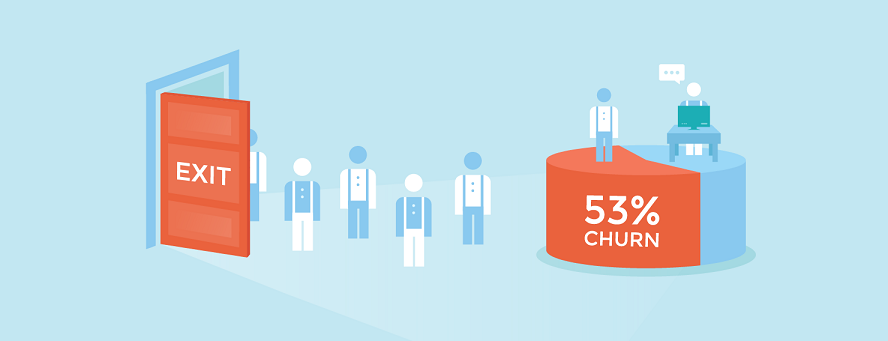

**Логистическая регрессия** - это линейный классификатор, который кроме классов умеет предсказывать вероятности классов.

Модель делает предсказания по формуле
$$a(x) = \sigma(w_0 + w_1x_1 + w_2x_2 + ...),$$
то есть умножает признаки объекта $x_1,x_2,...$ на некоторые веса $w_0,w_1,w_2,...$

Например, если 
* $x_1$ - возраст клиента
* $x_2$ - число жалоб клиента на банк, 
то обученная модель может иметь вид
$$a(x) = \sigma(10 - 3x_1 + 50x_2)$$

Веса модели подбираются автоматически так, чтобы ошибка предсказания модели была минимальной.

Функция $\sigma(x)$ - переводит предсказания модели в вероятности:

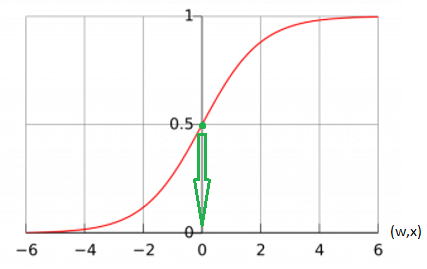

Давайте применим логистическую регрессию для поиска оттоковых клиентов!

Сначала выкинем нечисловые столбцы.

In [ ]:
X = X.drop(['state','areacode','voicemailplan','internationalplan'], axis=1)

In [ ]:
X.head()

Разобъём данные на train и test (test — 25% от всех данных). Зачем это делается?

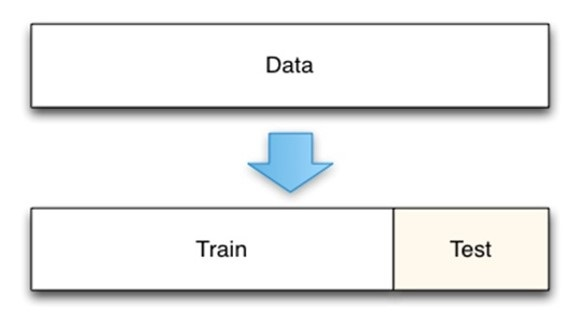

Мы разбиваем данные на train и test, чтобы:
* на тренировочных данных обучить модель
* на тестовых применить обученную модель и затем проверить качество модели

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

## Вопрос для Quiz

В одинаковых ли масштабах измеряются признаки клиентов?

Для ответа на этот вопрос выведите на экран первые несколько строчек таблицы X (вам поможет функция head).

In [ ]:
# your code here

Для линейных моделей очень важно масштабирование признаков. Поэтому отмасштабируем признаки при помощи StandardScaler, обучив метод на тренировочных данных и применив его и к трейну, и к тесту.

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(Xtrain)

Xtrain = pd.DataFrame(ss.transform(Xtrain), columns=X.columns)
Xtest = pd.DataFrame(ss.transform(Xtest), columns=X.columns)

Xtrain.head()

Обучим логистическую регрессию на train и сделаем предсказание на новых для нее данных (test).

In [ ]:
from sklearn.linear_model import LogisticRegression # линейная модель для задачи классификации

model = LogisticRegression() # объявление модели

model.fit(Xtrain, ytrain) # обучение модели

In [ ]:
pred_test = model.predict(Xtest) # предсказание классов

Посмотрим на предсказания модели и оценим ее качество.

In [ ]:
pred_test

In [ ]:
accuracy_score(ytest, pred_test) 

## Вопрос для Quiz

Доля верно определенных классов высокая! Значит ли это, что качество хорошее?


Проверим, сбалансирована ли выборка.

In [ ]:
y.value_counts()

Баланса классов нет: большинство клиентов не собирается менять банк ($y=0$). 

Посмотрим, что предсказывает модель.

In [ ]:
pred_test[:20]

## <font color='green'>2.2. Валидация модели</font>

Для оценки качества модели используются различные метрики качества. Давайте посмотрим, какие метрики полезно считать в задаче классификации, кроме accuracy.

<font color='blue'>Для оценки качества моделей бинарной классификации полезно смотреть на **матрицу ошибок** (confusion matrix):</font>

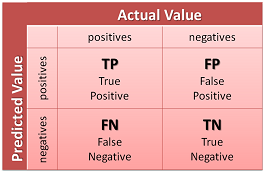

Эта матрица состоит из четырех чисел:

* **True Positive (TP)** - количество объектов положительного класса, предсказанных моделью как положительные (верные предсказания)
* **False Positive (FP)** - количество объектов отрицательного класса, предсказанных моделью как положительные (ошибки модели)
* **False Negative (FN)** - количество объектов положительного класса, предсказанных моделью как отрицательные (ошибки модели)
* **True Negative (TN)** - количество объектов отрицательного класса, предсказанных моделью как отрицательные (верные предсказания).

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(ytest, pred_test)

In [ ]:
ytest.value_counts()

Модель верно определила очень мало оттоковых клиентов :(

<font color='blue'>Также можно посмотреть на метрику **recall (полнота)** - она показывает, какую долю оттоковых клиентов (объектов положительного класса) нашла модель.</font>

In [ ]:
from sklearn.metrics import recall_score

recall_score(ytest, pred_test)

## Вопрос для Quiz

Что означает это значение метрики recall?

Давайте разберемся, почему так произошло?

Посмотрим на вероятности, выдаваемые моделью.

In [ ]:
probs = model.predict_proba(Xtest)

probs[:10]

Модель слишком позитивна. Она присваивает классу 0 (клиент не уйдет) всегда большие вероятности. 

<font color='blue'>Попробуем изменить **порог для перевода вероятности в классы** со стандартного 0.5 на порог поменьше.</blue>

In [ ]:
probs_churn = probs[:,1]

classes = probs_churn > 0.2

In [ ]:
confusion_matrix(ytest, classes)

In [ ]:
ytest.value_counts()

In [ ]:
recall_score(ytest, classes)

Теперь модель стала находить оттоковых клиентов, но и больше ошибается на тех клиентах, которые не уйдут.

## <font color='green'>3. Интерпретация модели</font>

После обучения модели можно посмотреть на её веса, то есть на коэффициенты при признаках, найденные моделью.

In [ ]:
model.coef_, model.intercept_

In [ ]:
import pandas as pd

coef_table = pd.DataFrame({'features' : list(X.columns), 'weights' : list(model.coef_[0])})

coef_table.sort_values(by='weights')

Если вес у признака положительный, то признак вносит положительный вклад в ответ, то есть чем больше значение признака, тем больше это дает вклад в положительный класс объекта и наоборот.

## Метод ближайших соседей (бонус)

Существует еще один простой метод для решения задач классификации - метод ближайших соседей.

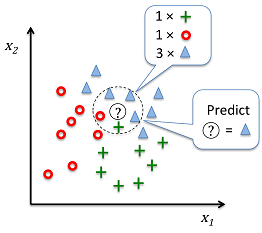

Попробуем применить метод ближайших соседей для решения поставленной задачи.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

In [ ]:
knn.fit(Xtrain, ytrain)

pred_test2 = knn.predict_proba(Xtest)[:,1]

classes2 = pred_test2 > 0.1

confusion_matrix(ytest, classes2)

## Вопрос для Quiz

Вычислите recall (долю найденных моделью оттоковых клиентов) при пороге 0.1. Ответ не округляйте.

In [ ]:
# your code here

## <font color='green'>4. Сохранение результатов экспериментов</font>

Что сохраняем?

* Предсказания модели
* Эксперименты
* Модель

Сначала сохраним предсказания модели в файл:

In [ ]:
Xtest['predictions'] = probs_churn

Xtest[['predictions']].to_csv("PredictionsChurn.csv", index=False)

Теперь сохраним саму модель:

In [ ]:
import pickle 

with open('model.pickle', 'wb') as f:
    pickle.dump(model, f)

# а так модель можно загрузить из файла:  
# with open('filename.pickle', 'rb') as f:
#     model = pickle.load(f)

Сохраним полученную модель, файл с предсказаниями и ноутбук с экспериментами на гитхаб.

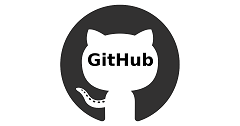

## <font color='green'>5. Градиентный бустинг</font>

Мы поработали с линейными моделями. Они весьма и весьма простые — предполагают независимость признаков и линейную связь между каждым признаком и целевой переменной. Конечно, в наших данных вряд ли всё так просто. Можно пытаться усложнять линейные модели: добавлять нелинейные признаки, переходить в новое признаковое пространство. Но это всё полумеры.

Сейчас мы поработаем с градиентным бустингом — одним из самых мощных подходов для работы с табличными данными.

Пока не ушли далеко — посчитаем и запомним качество логистической регрессии.

In [ ]:
from sklearn import metrics

print("LR quality:")
print("precision: ", metrics.precision_score(ytest, classes))
print("recall: ", metrics.recall_score(ytest, classes))
print("auc-roc: ", metrics.roc_auc_score(ytest, probs[:, 1]))

Есть много имплементаций градиентного бустинга. Мы будем пользоваться CatBoost — библиотекой от Яндекса, которая очень эффективно написана и широко используется в мире.

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier, Pool

In [ ]:
train_set = Pool(Xtrain, ytrain)
test_set = Pool(Xtest, ytest)

In [ ]:
gbm = CatBoostClassifier(iterations=100,
                          depth=2,
                          learning_rate=0.1,
                          loss_function='Logloss',
                          eval_metric='AUC',
                          verbose=False)
gbm.fit(train_set, eval_set=test_set)
gbm_preds = gbm.predict_proba(Xtest)

In [ ]:
eval_metrics = gbm.get_evals_result()
plt.plot(eval_metrics['validation']['AUC'])
plt.xlabel('n_trees')
plt.ylabel('AUC')
plt.grid()

In [ ]:
gbm_classes = (gbm_preds[:, 1] > 0.3)
print("precision: ", metrics.precision_score(ytest, gbm_classes))
print("recall: ", metrics.recall_score(ytest, gbm_classes))
print("auc-roc: ", metrics.roc_auc_score(ytest, gbm_preds[:, 1]))

In [ ]:
coef_table = pd.DataFrame({'features' : list(X.columns), 'importances' : list(gbm.get_feature_importance())})

coef_table.sort_values(by='importances')

## Вопрос для Quiz

Попробуйте обучить градиентный бустинг с другой длиной шага. Получится ли улучшить AUC-ROC на тесте?

In [ ]:
# ваш код здесь

## <font color='green'>6. Обработка категориальных признаков</font>

Выше мы удаляли все категориальные столбцы:

`X = X.drop(['state','areacode','voicemailplan','internationalplan'], axis=1)`

А вдруг там содержится много полезной информации? Попробуем её сохранить.

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_full, y, test_size=0.25, random_state=42)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical = ['state','areacode','voicemailplan','internationalplan']
numeric_features = X.columns

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

X_transformed = column_transformer.fit_transform(Xtrain)
X_test_transformed = column_transformer.transform(Xtest)

In [ ]:
X_transformed.shape

In [ ]:
model = LogisticRegression()
model.fit(X_transformed, ytrain)
pred = model.predict_proba(X_test_transformed)

In [ ]:
classes = (pred[:, 1] > 0.5)
print("precision: ", metrics.precision_score(ytest, classes))
print("recall: ", metrics.recall_score(ytest, classes))
print("auc-roc: ", metrics.roc_auc_score(ytest, pred[:, 1]))

In [ ]:
train_set = Pool(X_transformed, ytrain)
test_set = Pool(X_test_transformed, ytest)
gbm = CatBoostClassifier(iterations=100,
                          depth=2,
                          learning_rate=0.1,
                          loss_function='Logloss',
                          eval_metric='AUC',
                          verbose=False)
gbm.fit(train_set, eval_set=test_set)
gbm_preds = gbm.predict_proba(test_set)
gbm_classes = (gbm_preds[:, 1] > 0.3)
print("precision: ", metrics.precision_score(ytest, gbm_classes))
print("recall: ", metrics.recall_score(ytest, gbm_classes))
print("auc-roc: ", metrics.roc_auc_score(ytest, gbm_preds[:, 1]))